# NOTES:
- Waiting vs blocking  
--> blocking holds up everything (could be selective?)  
--> waiting for specific resources to reach inactive state (flags?)  

- Platemap vs positionmap
- Axes orientation

# TODO:
- tip touch
- get motor current position
- tip touch
- calibration
- initialization reference
- GUI
- pyVISA

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import ipywidgets as widgets
import serial as s
import yaml
import time
import sys
import numpy as np
import pandas as pd
import csv
from __future__ import division

In [2]:
%matplotlib notebook

# MOTOR
Lin Engineering 
1. Determine appropriate velocity_max = microsteps/sec
2. Determine motor limits
3. Determine conv = microsteps/mm
4. Determine orientation (P+; D-)

In [9]:
# TODO: get current position for relative move
class Motor:
    def __init__(self, config_file, init=True):
        self.serial = s.Serial() # placeholder

        f = open(config_file, 'r')
        self.config = yaml.load(f)
        f.close()
        
        if init:
            self.initialize()

    def initialize(self):
        self.serial = s.Serial(**self.config['serial']) # open serial connection
        
        # TODO set moving current
        # TODO set holding current
        self.set_velocity(self.config['velocity_limit'])  # set velocity
        self.home() # move motor to home
        
    def cmd(self, cmd_string, block=True):
        full_string = self.config['prefix'] + cmd_string + self.config['terminator']
        self.serial.write(full_string)
        
        time.sleep(0.15) # TODO: monitor for response?
        response = self.serial.read(self.serial.inWaiting()).decode('utf8', 'ignore')
        
        while block and self.is_busy():
            pass
           
        return response
    
    def is_busy(self):
        cmd_string = 'Q'
        time.sleep(0.05)
        response = self.cmd(cmd_string, False)
        return response.rfind('`') == -1
    
    
    # velocity: (usteps/sec) 
    def set_velocity(self, velocity):
        if velocity > self.config['velocity_limit']:
            velocity = self.config['velocity_limit']
            print 'ERR: Desired velocity exceeds velocity_limit; velocity now set to velocity_limit'
            
        cmd_string = 'V{}R'.format(velocity)
        return self.cmd(cmd_string)
       
    def halt(self):
        cmd_string = 'T'
        self.cmd(cmd_string)
    
    def home(self):
        cmd_string = 'Z{}R'.format(self.config['ustep_max'])
        return self.cmd(cmd_string)
    
    def move(self, mm, block=True):
        ustep = int(self.config['conv']*mm)
        if ustep > self.config['ustep_max']:
            ustep = self.config['ustep_max']
            print 'ERR: Desired move to {} mm exceeds max of {} mm; moving to max instead'.format(mm, self.config['ustep_max']/self.config['conv'])
        if ustep < self.config['ustep_min']:
            ustep = self.config['ustep_min']
            print 'ERR: Desired move to {} mm exceeds min of {} mm; moving to min instead'.format(mm, self.config['ustep_min']/self.config['conv'])
            
        cmd_string = 'A{}R'.format(ustep)
        
        return self.cmd(cmd_string, block)
        
    def move_relative(self, mm):
        ustep = int(self.config['conv']*mm)
        ustep_current = int(self.config['ustep_max']/2)  # TODO: limit movement (+ and -)
        
        if mm >= 0:
            if (ustep_current + ustep) > self.config['ustep_max']:
                ustep = self.config['ustep_max'] - ustep_current
                print 'ERR: Desired move of +{} mm exceeds max of {} mm; moving to max instead'.format(mm, self.config['ustep_max']/self.config['conv'])
            cmd_string = 'P{}R'.format(ustep)
        
        else:
            if (ustep_current + ustep) < self.config['ustep_min']:
                ustep = self.config['ustep_min'] - ustep_current
                print 'ERR: Desired move of {} mm exceeds min of {} mm; moving to min instead'.format(mm, self.config['ustep_min']/self.config['conv'])
            ustep = -1*ustep
            cmd_string = 'D{}R'.format(ustep)
        
        return self.cmd(cmd_string)
    
    def exit(self):
        self.serial.close()

In [ ]:
m = Motor('config/le_motor.yaml')

In [ ]:
m.serial.write('/1Q\r')
time.sleep(0.5)
m.serial.read(m.serial.inWaiting())

In [ ]:
m.cmd('Z1000R')

In [ ]:
print m.move(32)
time.sleep(1)
print m.move(20)

In [ ]:
print m.cmd('P100000D100000P100000D100000P100000D100000P100000D100000R')
print m.cmd('/1?0')

In [ ]:
m.exit()

# ASI Controller
Applied Scientific Instrumentation

1. Set hall effect sensors to appropriate limits
2. Determine orientation (X+-, Y+-)

In [6]:
# TODO: Fix serial.read encoding
class ASI_Controller:
    def __init__(self, config_file, init=True):
        self.serial = s.Serial() # placeholder
        
        f = open(config_file, 'r')
        self.config = yaml.load(f)
        f.close()
        
        if init:
            self.initialize()

    def initialize(self):
        self.serial = s.Serial(**self.config['serial']) # open serial connection

        self.cmd_xy('mc x+ y+')  # enable motor control for xy
        self.cmd_z('mc z+') # enable motor control for z

        print "Initializing stage..."
        self.move_xy(2000, -2000)  # move to switch limits (bottom right)
        self.r_xy(-0.5, 0.5)  # move from switch limits 0.5 mm


    def cmd(self, cmd_string):
        full_string = self.config['prefix'] + cmd_string + self.config['terminator']
        self.serial.write(full_string)
        time.sleep(0.05)
        response = self.serial.read(self.serial.inWaiting())
        return response
    
    def halt(self):
        self.halt_xy()
        self.halt_z()
    
    
    # XY ----------------------------------------------
    def cmd_xy(self, cmd_string, block=True):
        full_string = '2h ' + cmd_string
        response = self.cmd(full_string)
        
        while block and self.is_busy_xy():
            time.sleep(0.05)
            pass
         
        return response
    
    def is_busy_xy(self):
        status = self.cmd('2h STATUS')[0]
        return status == 'B'

    def halt_xy(self):
        self.cmd_xy('HALT', False)

    def move_xy(self, x_mm, y_mm):
        conv = self.config['conv']
        xStr = 'x=' + str(float(x_mm) * conv)
        yStr = 'y=' + str(float(y_mm) * conv)
        return self.cmd_xy(' '.join(['m', xStr, yStr]))
    
    def r_xy(self, x_mm, y_mm):
        conv = self.config['conv']
        xStr = 'x=' + str(float(x_mm) * conv)
        yStr = 'y=' + str(float(y_mm) * conv)
        return self.cmd_xy(' '.join(['r', xStr, yStr]))

    # Z -----------------------------------------------
    def cmd_z(self, cmd_string, block=True):
        while block and self.is_busy_z():
            time.sleep(0.3)
        full_string = '1h ' + cmd_string
        return self.cmd(full_string)
    
    def is_busy_z(self):
        status = self.cmd('1h STATUS')
        return status[0] == 'B'

    def halt_z(self):
        self.cmd_z('HALT', False)
    
    def move_z(self, z_mm):
        conv = self.config['conv']
        zStr = 'z=' + str(float(z_mm) * conv)
        return self.cmd_z(' '.join(['m', zStr]))   
    
    def r_z(self, z_mm):
        conv = self.config['conv']
        zStr = 'z=' + str(float(z_mm) * conv)
        return self.cmd_z(' '.join(['r', zStr]))
    
    def exit(self):
        self.serial.close()

In [4]:
a = ASI_Controller('config/asi_controller.yaml')

2h mc x+ y+
2h STATUS
1h STATUS
1h mc z+
Initializing stage...
2h m x=20000000.0 y=-20000000.0
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h STATUS
2h r x=-5000.0 y=5000.0
2h STATUS
2h STATUS
2h STATUS


In [5]:
a.exit()

# Autosipper

In [7]:
# I: filepath of delimited file
# P: detect delimiter/header read file accordingly
# O: list of records (no header)
def read_delim(filepath):
    f = open(filepath, 'r')
    dialect = csv.Sniffer().sniff(f.read(1024))
    f.seek(0)
    hasHeader = csv.Sniffer().has_header(f.read(1024))
    f.seek(0)
    reader = csv.reader(f, dialect)

    if hasHeader:
        reader.next()

    ret = [line for line in reader]
    return ret

def read_delim_pd(filepath):
    f = open(filepath)
    has_header = None
    if csv.Sniffer().has_header(f.read(1024)):
        has_header = 0
    f.seek(0)
    return pd.read_csv(f, header=has_header, sep=None, engine='python')

def lookup(table, columns, values):
    temp_df = pd.DataFrame(data=[values], columns = columns, copy=False)
    return table.merge(temp_df, copy=False)

In [8]:
class Autosipper:
    def __init__(self, xy, z):
        self.Z = z    # must be initialized first!
        self.XY = xy
        

        while True:
            fp = raw_input('Type in plate map file:')
            try:
                self.load_platemap(fp)  # load platemap
                break
            except IOError:
                print 'No file', fp

        raw_input('Place dropper above reference (press enter when done)')
        self.XY.cmd_xy('here x y')  # establish current position as 0,0
    
    def load_platemap(self, filepath):
        self.platemap = read_delim_pd(filepath)

    def go_to(self, columns, values):
        x1,y1,z1 = np.array(lookup(self.platemap, columns, values)[['x','y','z']])[0]

        self.Z.home()          # move needle to travel height (blocking)
        self.XY.move_xy(x1,y1) # move stage (blocking)
        self.Z.move(z1)        # move needle to bottom of well (blocking)
    
    def exit(self):
        self.XY.exit()
        self.Z.exit()

In [10]:
d = Autosipper(ASI_Controller('config/asi_controller.yaml'), Motor('config/le_motor.yaml'))

Initializing stage...
Type in plate map file:platemaps/384
Place dropper above reference (press enter when done)


In [11]:
d.platemap

,n,s,r,c,name,x,y,z
0,0,0,0,0,A01,0.0,0.0,70
1,1,1,0,1,A02,-4.5,0.0,70
2,2,2,0,2,A03,-9.0,0.0,70
3,3,3,0,3,A04,-13.5,0.0,70
4,4,4,0,4,A05,-18.0,0.0,70
5,5,5,0,5,A06,-22.5,0.0,70
6,6,6,0,6,A07,-27.0,0.0,70
7,7,7,0,7,A08,-31.5,0.0,70
8,8,8,0,8,A09,-36.0,0.0,70
9,9,9,0,9,A10,-40.5,0.0,70


<IPython.core.display.Javascript object>


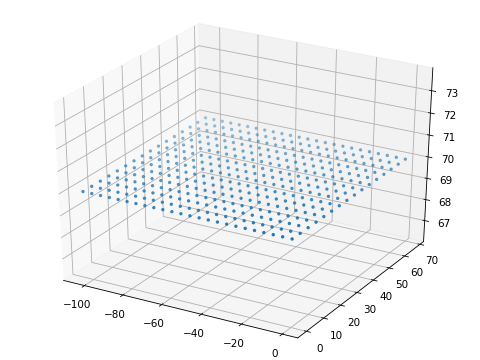

In [12]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(d.platemap['x'], d.platemap['y'], d.platemap['z'], s=5)
plt.show()

In [32]:
d.Z.move(88.5)

u'/0@\x03\r\n'

In [26]:
d.go_to(['name'],'M01')

In [ ]:
d.exit()

# PlatemapGen

## Calibration procedure:
Could also have dedicated reference position.   
PositionMap describes the whole deck layout. 
Define XYZ limits
Define travel height as min
1. Move needle tip to some reference point (e.g. center-bottom of well A01 of top plate). Record $X_r$ $Y_r$ $Z_r$.
2. Move

Define limits of hardware

In [ ]:
# I:
# row_col_num: (ct, ct) 2-tuple of 
# row_col_spacing: (mm, mm)
# well_top_bottom_diameter: (mm, mm, mm)
# O: 
def generate_platemap(row_col_num, row_col_spacing, well_top_bottom_diameter):
    print 'n','s','r','c','name','x','y','z'
    for r in range(row_col_num[0]):
        for c in range(row_col_num[1]):
            n = c + (r)*row_col_num[1]
            s = ((r+1)%2)*(c + r*row_col_num[1]) + (r%2)*((r+1)*row_col_num[1] - (c+1))
            name = chr(64+r+1) + '{:02d}'.format(c+1)
            x = -c*row_col_spacing[1]
            y = r*row_col_spacing[0]
            z = well_top_bottom_diameter[1]
            print n, s, r, c, name, x, y, z

row_col_num = 16,24
row_col_spacing = 4.5,4.5
well_top_bottom_diameter = 18,30,8
generate_platemap(row_col_num, row_col_spacing, well_top_bottom_diameter)

# Communication: PyVISA

Install NI-VISA:
https://pyvisa.readthedocs.io/en/stable/getting_nivisa.html

In [ ]:
import visa

In [ ]:
rm = visa.ResourceManager()

In [ ]:
rm.list_resources()

In [ ]:
rm.list_resources_info()

# Documentation: Sphinx

http://thomas-cokelaer.info/tutorials/sphinx/docstring_python.html

# GUI: pywidgets.interact

http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html

In [ ]:
x_minus = widgets.Button(
    description='<',
    disabled=False,
    button_style='',
    icon='check')

x_plus = widgets.Button(
    description='>',
    disabled=False,
    button_style='',
    icon='check')

y_minus = widgets.Button(
    description='^',
    disabled=False,
    button_style='', 
    icon='check', )

y_plus = widgets.Button(
    description='v',
    disabled=False,
    button_style='',
    icon='check')

xy_slider = widgets.VBox([widgets.FloatText(description='speed', width='50%',value=50),widgets.IntSlider(width=130, step=10)])
xy_cluster = widgets.VBox([ widgets.HBox([x_minus,x_plus]), widgets.HBox([y_minus, y_plus]) ])


z_minus = widgets.Button(
    description='^',
    disabled=False,
    button_style='', 
    icon='check')

z_plus = widgets.Button(
    description='v',
    disabled=False,
    button_style='',
    icon='check')

z_slider = widgets.VBox([widgets.FloatText(description='speed', width='50%',value=50),widgets.IntSlider(width=130, step=10)])
z_cluster = widgets.VBox([ z_minus, z_plus])


display(widgets.HBox([xy_cluster, xy_slider, z_cluster, z_slider]))

In [ ]:
f = open('config/le_motor.yaml')
config = yaml.load(f)
f.close()

In [ ]:
a = Motor('config/le_motor.yaml')